In [1]:
from nltk.corpus import movie_reviews
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
# Считываем данные
test = pd.read_csv('products_sentiment_test.tsv', sep='\t')
train = pd.read_csv('products_sentiment_train.tsv', sep='\t',  header=None)
classes = pd.read_csv('products_sentiment_sample_submission.csv')
print(test.shape, train.shape, classes.shape)

(500, 2) (2000, 2) (500, 2)


In [3]:
test

,Id,text
0,0,"so , why the small digital elph , rather than ..."
1,1,3/4 way through the first disk we played on it...
2,2,better for the zen micro is outlook compatibil...
3,3,6 . play gameboy color games on it with goboy .
4,4,"likewise , i 've heard norton 2004 professiona..."
...,...,...
495,495,i took perfect care of this player and still i...
496,496,it 's a very intuitive program .
497,497,the only drawback is the viewfinder is slightl...
498,498,"it films 10 second video , for crying out loud ."


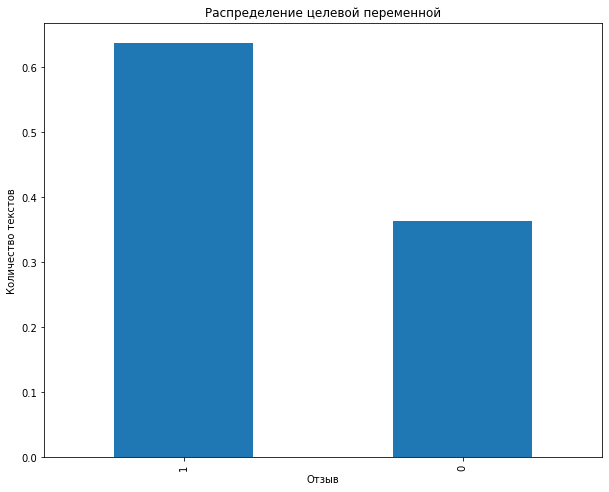

In [5]:
# Смотрим распределение целевой переменной
fig = plt.figure(figsize=(10, 8))
y.value_counts(normalize=True).plot(kind='bar');
plt.title("Распределение целевой переменной");
plt.xlabel("Отзыв");
plt.ylabel("Количество текстов");

In [6]:
# Делаем из датафрейма сериес
test = test['text']
train = train[0]
print('test = ', test.iloc[5])
print('train = ', train.iloc[5])


test =  mine was 2 weeks old and i chucked it in the trash , where it belongs . 
train =  you can manage your profile , change the contrast of backlight , make different type of display , either list or tabbed . 


In [ ]:
# Смотрим количество фич
cv = CountVectorizer()
X = cv.fit_transform(train)
print(X.shape[1])

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import nltk
nltk.download('stopwords')
stop = nltk.corpus.stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lesika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = stop,   \
                             max_features = 5000) 


#train_data_features = vectorizer.fit_transform(train)

#train_data_features = train_data_features.toarray()
#train_data_features.shape, y.shape

In [ ]:
# строим пайплан и модель на линейной регрессии
pipe = Pipeline([
    ('сv', vectorizer),
    ('logreg', LogisticRegression(solver = 'liblinear'))])
accuracy = cross_val_score(pipe, train, y, cv=5, scoring='accuracy' )
print('accuracy на линейной регрессии, при наличии стоп слов и без токинезации равно {}'.format(accuracy.mean()))

In [ ]:
# Пробуем разные модели с разными параметрами

In [ ]:
pipe = Pipeline([
    ('сv', vectorizer),
    ('forest', RandomForestClassifier(n_estimators = 100))])
accuracy = cross_val_score(pipe, train, y, cv=5, scoring='accuracy' )
print('accuracy на случайном лесе (100 эстиматоров), при наличии стоп слов и без токинезации равно {}'.format(accuracy.mean()))

In [ ]:
pipe = Pipeline([
    ('сv', vectorizer),
    ('forest', RandomForestClassifier(n_estimators = 500))])
accuracy = cross_val_score(pipe, train, y, cv=5, scoring='accuracy' )
print('accuracy на случайном лесе (500 эстиматоров), при наличии стоп слов и без токинезации равно {}'.format(accuracy.mean()))

In [ ]:
params_grid_vectorizer = {
    'vectorizer__max_df' : [0.85, 0.9, 0.95, 1.0],
    'vectorizer__min_df' : [1, 10, 20], 
    'vectorizer__ngram_range' : [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)],
    'vectorizer__stop_words' : [stop, None, 'english']
}

In [8]:
def make_pipeline(vectorizer,  dense,pca, classifier):
    return Pipeline([
            ('vectorizer', vectorizer),
            #('transformer', transformer),
            ('dense',dense),
            ('pca', pca),
            ('classifier', classifier)
        ])

In [9]:
def make_estimator(classifier, params_grid, scorer, data, labels):
    pipeline = make_pipeline(CountVectorizer(), TfidfTransformer(), classifier)
    grid_cv = RandomizedSearchCV(pipeline, params_grid, scoring=scorer, cv=5, random_state=777, n_iter=100)
    grid_cv.fit(data, labels)
    return grid_cv

In [10]:
class DenseTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:
%%time
for name, clf in {'LogisticRegression': LogisticRegression, 'LinearSVC': LinearSVC, 
               'SGDClassifier': SGDClassifier, 'RidgeClassifier': RidgeClassifier}.items():
    score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777)), train, y, cv=5).mean()
    print(f"{name} - {score}")

In [ ]:
%%time
models={}
for name, clf in {'LogisticRegression': LogisticRegression, 'LinearSVC': LinearSVC, 
               'SGDClassifier': SGDClassifier, 'RidgeClassifier': RidgeClassifier}.items():
    print(name)
    models[name]=make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777)).fit(train,y)
    #models[name]=make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777, class_weight='balanced')).fit(train,y)
yp = models['LogisticRegression'].predict(train)
confusion_matrix(y,yp)

In [ ]:
array([[ 690,   36],
       [ 140, 1134]], dtype=int64)

In [ ]:
models['LogisticRegression'].fit(train,y)

### Так как целевая переменная не сбалансирована, добавим 500 негативных отзывов в обучающую выборку и сравним результат.

In [ ]:

train = pd.read_csv('products_sentiment_train.tsv', sep='\t',  header=None)
train = shuffle(train.append(train.iloc[list(train[train[1] == 0].index[:500])]), random_state=10)
y = train[1]
X = train[0]
y, X

In [ ]:
# И снова прогоняем наши модели

In [ ]:
%%time
for name, clf in {'LogisticRegression': LogisticRegression, 'LinearSVC': LinearSVC, 
               'SGDClassifier': SGDClassifier, 'RidgeClassifier': RidgeClassifier}.items():
    score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777)), X, y, cv=5).mean()
    print(f"{name} - {score}")

In [ ]:
%%time
models={}
for name, clf in {'LogisticRegression': LogisticRegression, 'LinearSVC': LinearSVC, 
               'SGDClassifier': SGDClassifier, 'RidgeClassifier': RidgeClassifier}.items():
    models[name]=make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777)).fit(X,y)
    

In [ ]:
yp = models['LogisticRegression'].predict(X)
confusion_matrix(y,yp)

In [ ]:
est = [145] #range(100, 200, 5)
m_s = [2]#, 3, 4]
regressor = RandomForestRegressor(random_state=0)
grid = {'n_estimators': est, 'min_samples_split': m_s}
gs = GridSearchCV(regressor, grid, scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 10 )
gs.fit(scaler.fit_transform(X_train), y_train)
y_pred = gs.predict(scaler.transform(X_test))
t = mean_squared_error(y_test, y_pred)
print(t, np.exp(t))
gs.best_params_


params_grid_lsvc = {
    'classifier__loss': ['hinge', 'squared_hinge'], 
    'classifier__max_iter': np.arange(100, 1000, 50),
    'classifier__tol': [1e-5, 1e-4, 1e-3],
    'classifier__C': np.arange(0.1, 2, 0.1)

In [ ]:
train.shape, y.shape

In [ ]:
# в этом месте я рыдаю, выкидываю все, что было раньше, и делаю все заново

In [11]:
vectorizer = TfidfVectorizer(min_df=0.02, max_df=0.9, ngram_range=(3,12), sublinear_tf=True, analyzer='char_wb')
classifier = LinearSVC()

In [12]:
grid={
    'classifier__loss': ['squared_hinge'], 
    'classifier__max_iter': np.arange(100, 1000, 50),
    'classifier__tol': [1e-5],
    'classifier__C': np.arange(0.1, 2, 0.1),
    'classifier__penalty': ['l2'],
    'classifier__class_weight': ['balanced', None],
    'classifier__dual':[True, False]
}

In [13]:
pipeline = Pipeline([('vectorizer', vectorizer), 
                    ('DenseTransformer', DenseTransformer()),
                     ('pca', PCA()),
                    ('classifier', classifier)])

In [15]:
gs = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs = 2, verbose = 10, error_score = 0.0)
gs.fit(train, y)
y_pred = gs.predict(train)




C:\Users\Lesika\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1368 candidates, totalling 4104 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   13.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   30.9s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   41.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  6.6min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Do

In [16]:
print(accuracy_score(y, y_pred))
print(gs.best_score_)
print(gs.best_params_)

0.8545
0.7745
{'classifier__C': 0.2, 'classifier__class_weight': None, 'classifier__dual': True, 'classifier__loss': 'squared_hinge', 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__tol': 1e-05}


In [ ]:
0.8855
0.983

In [ ]:
gs.best_params_

In [17]:
# Ну и постим все это на каггл. 
y_kaggle = gs.predict(test)
t = pd.DataFrame(y_kaggle).reset_index()
t.columns = ['Id', 'y']
t.to_csv('kaggle_6.csv', index = False)